In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import fisher_exact
from scipy.stats import spearmanr

In [3]:
plt.style.use('seaborn-poster')

In [4]:
fitOB = h5py.File('./ob-q2-log_rna_only-5-rand_batch/model-output-final.hdf5', 'r')

In [5]:
f = h5py.File('../ob_combined.hdf5','r')

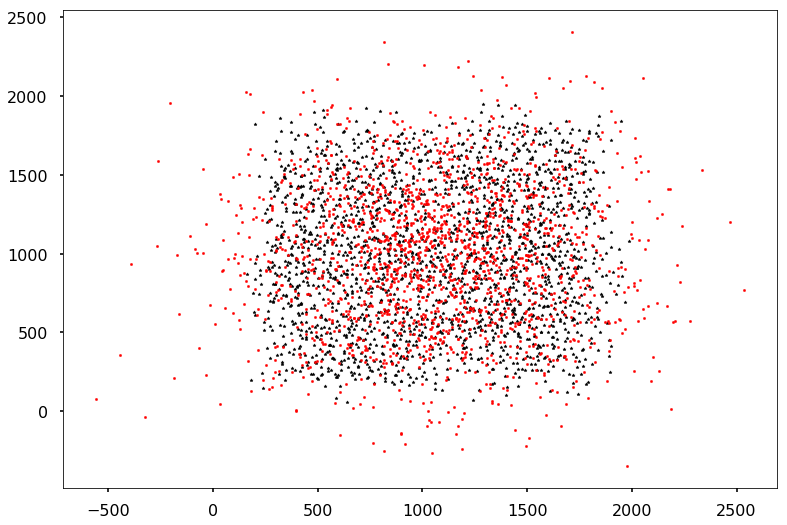

In [6]:
plt.subplot(111)
plt.scatter(f['coords'][:,0],f['coords'][:,1], s = 10.0, marker = '*', c = 'k')
plt.scatter(100*fitOB['zvar_init'][:,0],100*fitOB['zvar_init'][:,1], s = 5.0, marker = 'o', c = 'r')
plt.show()

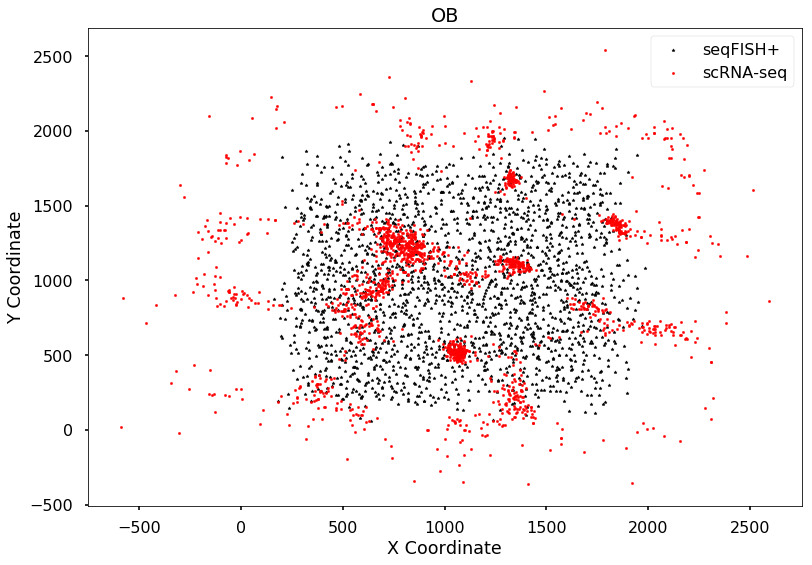

In [7]:
plt.subplot(111)
plt.scatter(f['coords'][:,0],f['coords'][:,1], s = 10.0, marker = '*', c = 'k', label = 'seqFISH+')
plt.scatter(100*fitOB['z_post'][2050:,0],100*fitOB['z_post'][2050:,1], s = 5.0, marker = 'o', c = 'r', label = 'scRNA-seq')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.title('OB')
plt.show()

In [8]:
celltype_annotations = pd.read_csv('../celltype_annotations/cortex_svz_cell_type_annotations.csv')

In [9]:
rna_seq = pd.read_csv('../GSE71585_RefSeq_counts.csv.gz')
meta = pd.read_csv('../GSE71585_Clustering_Results.csv.gz')
rna_seq_cells = rna_seq.columns[1:]
found = np.zeros(len(rna_seq_cells))

counter = 0
for i in rna_seq_cells:
    found[counter] = np.where(meta['sample_title'] == i)[0][0]
    #print(i)
    #print(rna_seq_cells[found[counter]])
    counter += 1
meta2 = meta.reindex(found)

In [10]:
from sklearn.neighbors import NearestNeighbors

In [11]:
ob_max = np.max(fitOB['z_post'][:2050,], axis = 0)
ob_min = np.min(fitOB['z_post'][:2050,], axis = 0)
mask_max = fitOB['z_post'][2050:] < ob_max
mask_min = fitOB['z_post'][2050:] > ob_min
mask1 = np.logical_and(mask_max, mask_min)
mask_ob = np.logical_and(mask1[:,0],mask1[:,1])
np.sum(mask_ob)

1436

In [12]:
z_ob = fitOB['z_post'][2050:][mask_ob]
labs_ob = meta2['broad_type'].values[mask_ob]

In [13]:
n_rna = len(np.unique(labs_ob))
labs_rna = np.unique(labs_ob)
fig_labels = np.hstack(('', labs_rna))

In [14]:
type_bar = meta2['broad_type'][mask_ob].value_counts().index
type_counts = meta2['broad_type'][mask_ob].value_counts().values
type_counts_sort = type_counts[np.argsort(type_bar)]
count_norm = type_counts_sort/float(np.sum(type_counts_sort))

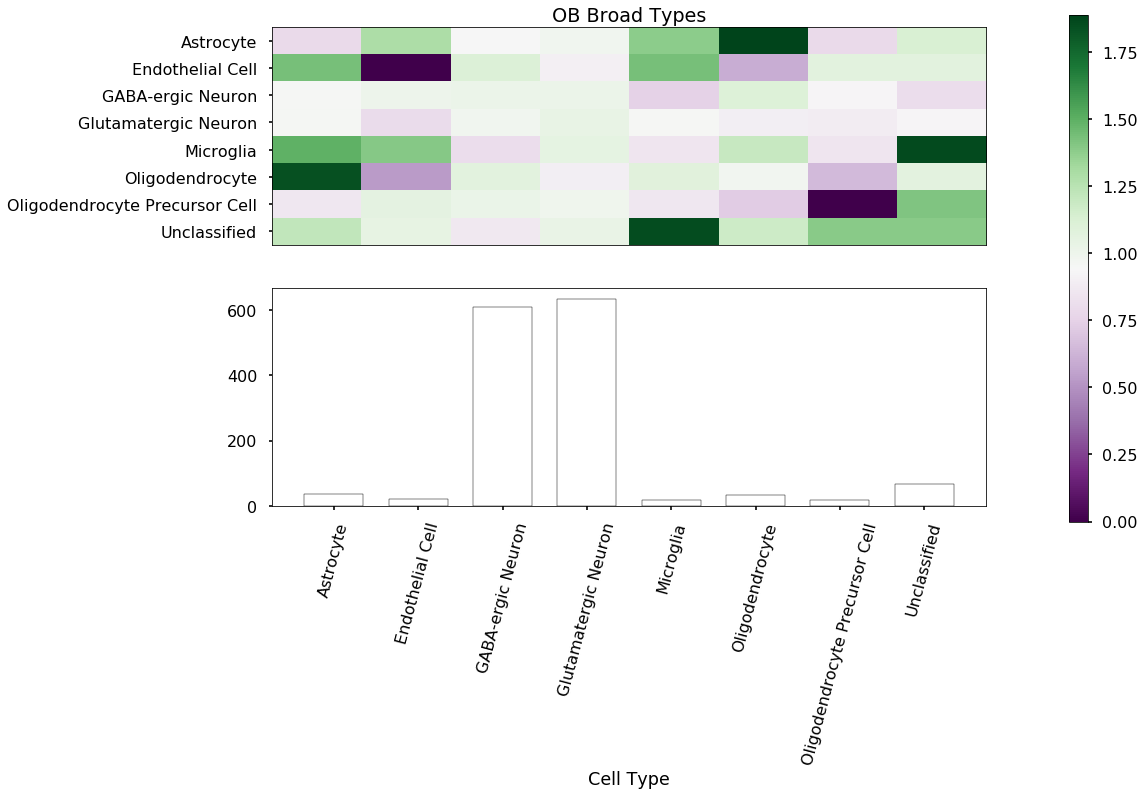

In [15]:
K = 15

knn = np.array(NearestNeighbors(n_neighbors = K).fit(z_ob).kneighbors_graph().todense())
mnn = np.multiply(knn, knn.T)
contingencyMNN = np.zeros((n_rna, n_rna))

for i in range(z_ob.shape[0]):
    i_nn = mnn[i,:]
    i_labs = labs_ob[i_nn.astype(bool)]
    
    i_ix = np.where(labs_rna == labs_ob[i])[0]
    
    for j in range(n_rna):
        maskj = i_labs == labs_rna[j]
        contingencyMNN[i_ix, j] += np.sum(maskj)
cmnnnorm = np.divide(contingencyMNN.T, np.sum(contingencyMNN, axis = 1)).T

fig, ax1 = plt.subplots(2,1)

im = ax1[0].imshow(np.divide(cmnnnorm,count_norm), cmap = 'PRGn', aspect = 'auto')
ax1[0].set_xticks(())
#ax1[0].set_xticklabels((''))
ax1[0].set_yticks(range(8))
ax1[0].set_yticklabels(labs_rna)
ax1[0].set_title('OB Broad Types')

#fig.colorbar(im, ax=ax1[0])
im2 = ax1[1].bar(np.linspace(0.5,8.5,8), type_counts_sort, color = '', edgecolor = 'k')
ax1[1].set_xticks(np.linspace(0.5,8.5,8))
ax1[1].set_xticklabels(labs_rna, rotation = 75)
plt.xlabel('Cell Type')

cb_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

plt.show()

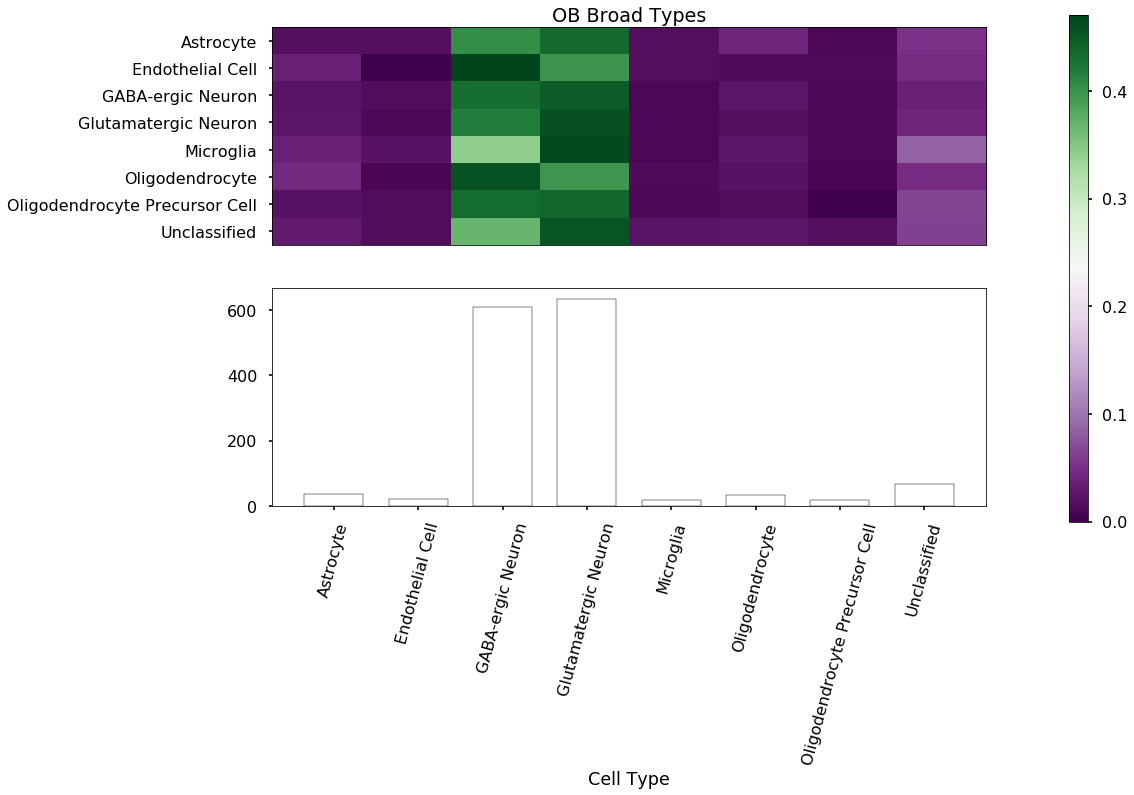

In [16]:
fig, ax1 = plt.subplots(2,1)

im = ax1[0].imshow(cmnnnorm, cmap = 'PRGn', aspect = 'auto')
ax1[0].set_xticks(())
#ax1[0].set_xticklabels((''))
ax1[0].set_yticks(range(8))
ax1[0].set_yticklabels(labs_rna)
ax1[0].set_title('OB Broad Types')

#fig.colorbar(im, ax=ax1[0])
im2 = ax1[1].bar(np.linspace(0.5,8.5,8), type_counts_sort, color = '', edgecolor = 'k')
ax1[1].set_xticks(np.linspace(0.5,8.5,8))
ax1[1].set_xticklabels(labs_rna, rotation = 75)
plt.xlabel('Cell Type')

cb_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

plt.show()

In [17]:
rel = np.divide(cmnnnorm,count_norm)

In [18]:
rel[4,1]

1.3962080700048614

In [19]:
print(np.array(contingencyMNN, dtype = int))

[[   8    8  163  176    7   17    4   21]
 [   8    0  105   89    4    3    3   11]
 [ 163  105 2940 3053   64  168   80  253]
 [ 176   89 3053 3340   87  146   81  313]
 [   7    4   64   87    2    5    2   16]
 [  17    3  168  146    5    8    3   18]
 [   4    3   80   81    2    3    0   12]
 [  21   11  253  313   16   18   12   44]]


In [20]:
# testor = rbind(c(8,8,163,176,7,17,4,21),c(8,0,105,89,4,3,3,11),c(163,105,2940,3053,64,168,80,253),c(176,89,3053,3340,87,146,81,313),c(7,4,64,87,2,5,2,16),c(17,3,168,146,5,8,3,18), c(4,3,80,81,2,3,0,12), c(21,11,253,313,16,18,12,44))
# fisher.test(testor, simulate.p.value=TRUE) in R

# data:  testor
# p-value = 0.0004998
# alternative hypothesis: two.sided

In [21]:
A = meta2['broad_type'][mask_ob].value_counts().values
B = meta2['broad_type'].value_counts().values
C = np.divide(1. * A, B)

In [22]:
in_v_out_ob = ttest_ind(f['rna_shared'][mask_ob,:].shape, f['rna_shared'][np.logical_not(mask_ob),:], equal_var = False)

In [23]:
# print(f['genes'][:][np.argsort(in_v_out_ob[1])][0:10])

In [24]:
# for i in np.unique(labs_ob):
#     cmask = labs_ob == i
#     plt.scatter(z_ob[cmask,0], z_ob[cmask,1], label = i, s = 25.0, alpha = 0.5)
# plt.legend()
# plt.show()

In [25]:
rnaseq = pd.read_csv('../GSE71585_RefSeq_counts.csv.gz')

In [26]:
counts = rnaseq.values[:,1:].T.astype(np.float32)

In [27]:
rnaseq.shape

(24057, 1810)

In [28]:
astrocyte_mask = meta2['broad_type'][mask_ob] == 'Astrocyte'

In [29]:
oligo_mask = meta2['broad_type'][mask_ob] == 'Oligodendrocyte'

In [30]:
neighbor_cells = np.where(mnn[astrocyte_mask][:,oligo_mask] == 1)

In [31]:
np.sort(np.unique(neighbor_cells[0]))

array([ 3,  6,  8,  9, 10, 13, 14, 18, 25, 29, 31, 34, 35])

In [32]:
astrocyte_full = counts[mask_ob][astrocyte_mask]
astro_ix = np.sort(np.unique(neighbor_cells[0]))
astrocyte_neighbors = astrocyte_full[astro_ix]
astro_nix = np.setdiff1d(range(astrocyte_full.shape[0]),astro_ix)
astrocyte_non = astrocyte_full[astro_nix]

In [33]:
astro_diff = ttest_ind(astrocyte_neighbors, astrocyte_non)

/Users/architverma/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/architverma/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/architverma/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [34]:
np.sum(astro_diff[1] < 0.01)

/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


21

In [35]:
rnaseq['gene'][astro_diff[1] < 0.005]

/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


1798     9130011J15Rik
7124             Espnl
8099              Gas5
10297          Hnrnpa3
13493           Mrps28
17704            Rbpjl
20700            Thoc7
20714          Thumpd3
Name: gene, dtype: object

In [36]:
astro_diff[0][astro_diff[1] < 0.01]

/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([ 2.8165016,  2.8542852,  3.4516592,  2.9264705,  2.8584306,
       -2.7374682,  3.0742416, -2.895974 ,  3.0550032,  2.7875984,
        3.107603 ,  3.3546047,  2.8029008,  2.7544281,  3.368684 ,
        2.8061223,  2.9365513,  2.8616107,  3.441835 ,  3.0415072,
        2.8508635], dtype=float32)

In [37]:
for i in np.where(astro_diff[1] < 0.005)[0]:
    print(rnaseq['gene'][i])
    print(astro_diff[1][i])
    print(astro_diff[0][i])

9130011J15Rik
0.0015082094985349795
3.4516592
Espnl
0.0041430162932183535
3.0742416
Gas5
0.004356410761594653
3.0550032
Hnrnpa3
0.0037962538783785226
3.107603
Mrps28
0.001964219108793047
3.3546047
Rbpjl
0.001890699191707047
3.368684
Thoc7
0.0015492790283344936
3.441835
Thumpd3
0.0045122726842046195
3.0415072


/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [38]:
oligo_full = counts[mask_ob][oligo_mask]
oligo_ix = np.sort(np.unique(neighbor_cells[1]))
oligo_neighbors = oligo_full[oligo_ix]
oligo_nix = np.setdiff1d(range(oligo_full.shape[0]),oligo_ix)
oligo_non = oligo_full[oligo_nix]

In [39]:
oligo_diff = ttest_ind(oligo_neighbors, oligo_non)

In [40]:
rnaseq['gene'][oligo_diff[1] < 0.005]

/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


4452       Cckar
4817      Cep110
7349     Fam165b
9538       Gnptg
10810       Insr
12193       Manf
13576      Mtch2
18144    Rpl22l1
18176      Rpl7a
20737    Timm17b
21654     Txnl4a
Name: gene, dtype: object

In [41]:
np.where(f['genes'][:] == 'Espn1')

(array([], dtype=int64),)

In [42]:
oligo_diff[0][oligo_diff[1] < 0.01]

/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([-2.7660866,  2.775623 ,  3.1880836, -2.8306513,  3.6762354,
        2.7554464,  3.2666085,  2.783921 ,  2.8278158,  3.107255 ,
        3.1608176, -2.9747756,  3.1232255,  3.3526676,  3.7038417,
       -3.27422  ,  2.7873538,  3.0517375,  2.7872043,  2.9048188,
        2.8082302,  2.8710306, -3.4215348,  2.8564034, -2.7645624,
        2.7549095], dtype=float32)

In [43]:
for i in np.where(oligo_diff[1] < 0.005)[0]:
    print(rnaseq['gene'][i])
    print(oligo_diff[1][i])
    print(oligo_diff[0][i])

Cckar
0.003339535474453218
3.1880836
Cep110
0.0009217893498391856
3.6762354
Fam165b
0.0027260377036104396
3.2666085
Gnptg
0.004107829195308846
3.107255
Insr
0.0035819173686041975
3.1608176
Manf
0.0039437737043774975
3.1232255
Mtch2
0.002178080073653065
3.3526676
Rpl22l1
0.0008556850297502667
3.7038417
Rpl7a
0.0026726807422163654
-3.27422
Timm17b
0.004730166414365775
3.0517375
Txnl4a
0.001817535576924298
-3.4215348


/Users/architverma/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [44]:
# labs_ob = meta2['primary_type'].values[mask_ob]
# n_rna = len(np.unique(labs_ob))
# labs_rna = np.unique(labs_ob)
# fig_labels = np.hstack(('', labs_rna))
# type_bar = meta2['primary_type'][mask_ob].value_counts().index
# type_counts = meta2['primary_type'][mask_ob].value_counts().values
# type_counts_sort = type_counts[np.argsort(type_bar)]
# count_norm = type_counts_sort/float(np.sum(type_counts_sort))


# K = 15

# knn = np.array(NearestNeighbors(n_neighbors = K).fit(z_ob).kneighbors_graph().todense())
# mnn = np.multiply(knn, knn.T)
# contingencyMNN = np.zeros((n_rna, n_rna))

# for i in range(z_ob.shape[0]):
#     i_nn = mnn[i,:]
#     i_labs = labs_ob[i_nn.astype(bool)]
    
#     i_ix = np.where(labs_rna == labs_ob[i])[0]
    
#     for j in range(n_rna):
#         maskj = i_labs == labs_rna[j]
#         contingencyMNN[i_ix, j] += np.sum(maskj)
# cmnnnorm = np.divide(contingencyMNN.T, np.sum(contingencyMNN, axis = 1)).T

# fig, ax1 = plt.subplots(2,1)
# im = ax1[0].imshow(np.divide(cmnnnorm,count_norm), cmap = 'PRGn', aspect = 'auto')
# ax1[0].set_xticks(())
# #ax1[0].set_xticklabels((''))
# ax1[0].set_yticks(())
# ax1[0].set_yticklabels((''))
# #fig.colorbar(im, ax=ax1[0])
# im2 = ax1[1].bar(np.linspace(0.5,n_rna+0.5,n_rna), type_counts_sort)
# ax1[1].set_xticks(np.linspace(0.5,n_rna+0.5,n_rna))
# ax1[1].set_xticklabels(labs_rna, rotation = 75, fontsize = 10)
# ax1[1].set_xlabel('Cell Type')

# ax1[0].set_title('OB Primary Types')
# cb_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])
# cbar = fig.colorbar(im, cax=cb_ax)


# plt.show()

In [45]:
# np.where(contingencyMNN == np.max(contingencyMNN))
# print(labs_rna[5])
# print(labs_rna[8])

In [46]:
knn_astro = NearestNeighbors(n_neighbors = 1).fit(z_ob[astrocyte_mask])

In [47]:
oligo_nn_dist, oligo_nn_ix = knn_astro.kneighbors(X = z_ob[oligo_mask])

In [48]:
espnl = counts[mask_ob][astrocyte_mask][oligo_nn_ix,7124]

SpearmanrResult(correlation=-0.37231625571464533, pvalue=0.03586495906997636)


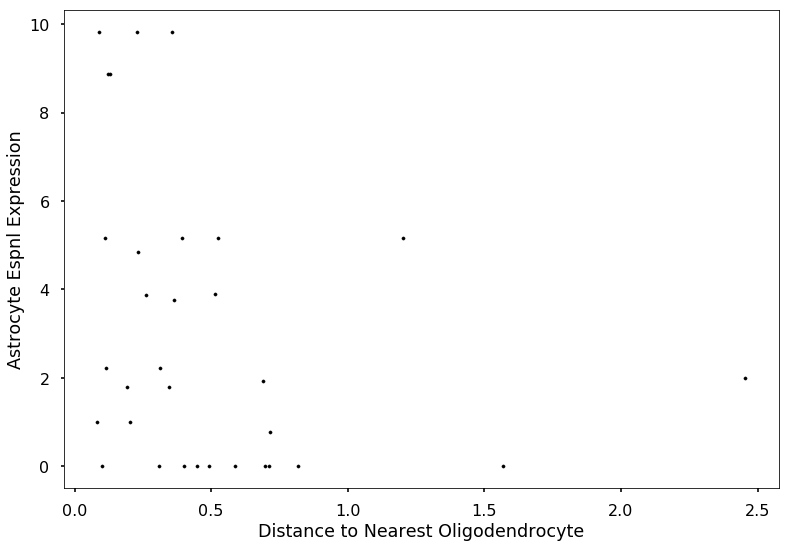

In [49]:
print(spearmanr(oligo_nn_dist, espnl))
plt.scatter(oligo_nn_dist, espnl, c = 'k', s = 10.0)
plt.xlabel('Distance to Nearest Oligodendrocyte')
plt.ylabel('Astrocyte Espnl Expression')
plt.show()

In [50]:
knn_oligo = NearestNeighbors(n_neighbors = 1).fit(z_ob[oligo_mask])

In [51]:
astro_nn_dist, astro_nn_ix = knn_oligo.kneighbors(X = z_ob[astrocyte_mask])

In [52]:
cckar = counts[mask_ob][oligo_mask][astro_nn_ix,4452]

SpearmanrResult(correlation=-0.49594710125874286, pvalue=0.0020978300582239176)


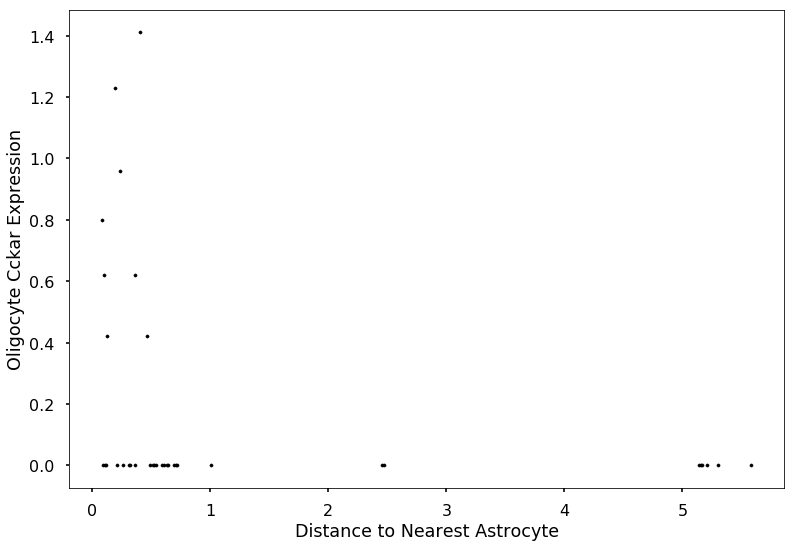

In [53]:
print(spearmanr(astro_nn_dist, cckar))
plt.scatter(astro_nn_dist, cckar, c = 'k', s = 10.0)
plt.xlabel('Distance to Nearest Astrocyte')
plt.ylabel('Oligocyte Cckar Expression')
plt.show()

In [54]:
from scipy import interpolate
from scipy.optimize import curve_fit

In [55]:
x = np.squeeze(astro_nn_dist)
y = np.squeeze(cckar)

In [56]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [57]:
popt, pcov = curve_fit(func, x, y)

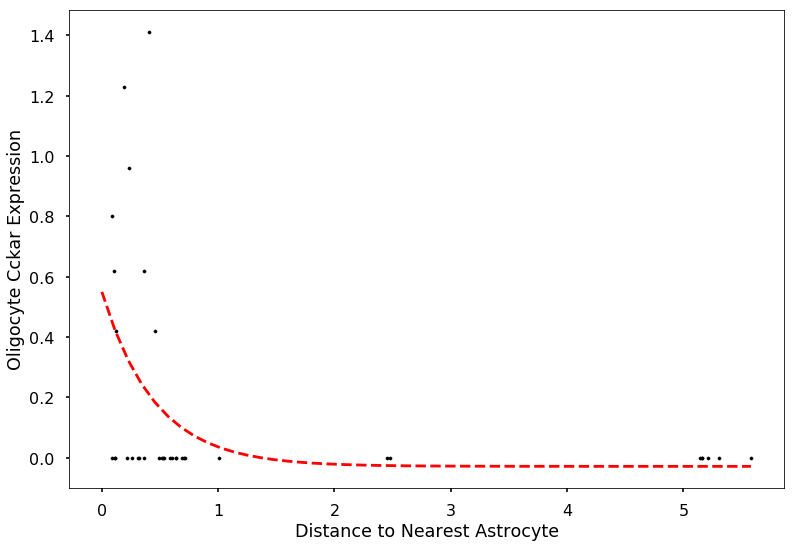

In [58]:
plt.scatter(x, y, c = 'k', s = 10.0, label='data')
plt.plot(np.linspace(0,np.max(x)), func(np.linspace(0,np.max(x)), *popt), 'r--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('Distance to Nearest Astrocyte')
plt.ylabel('Oligocyte Cckar Expression')
plt.show()

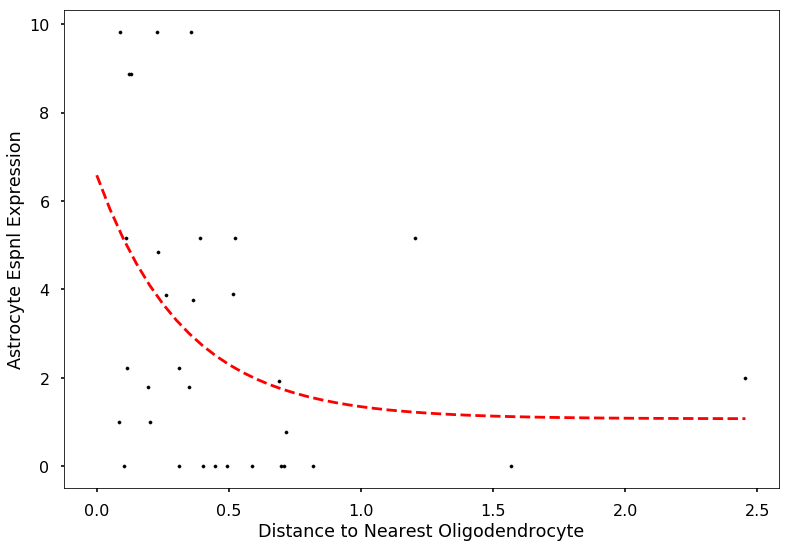

In [59]:
x = np.squeeze(oligo_nn_dist)
y = np.squeeze(espnl)
popt, pcov = curve_fit(func, x, y)
plt.scatter(x, y, c = 'k', s = 10.0, label='data')
plt.plot(np.linspace(0,np.max(x)), func(np.linspace(0,np.max(x)), *popt), 'r--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('Distance to Nearest Oligodendrocyte')
plt.ylabel('Astrocyte Espnl Expression')
plt.show()

In [60]:
rnaseq.shape

(24057, 1810)

In [61]:
f['genes']

<HDF5 dataset "genes": shape (9541,), type "|S11">